In [1]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import pandas as pd

import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('words')
from nltk.corpus import words
from nltk.corpus import wordnet
stop = stopwords.words()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\darklane\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\darklane\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\darklane\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\darklane\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [2]:
df = pd.read_csv('spam.csv')
df.drop_duplicates(subset=['EmailText'], inplace=True)
df.reset_index(drop=True, inplace=True)

In [3]:
df.groupby('Label').describe()

EmailText                                                               
          count unique                                                top freq
Label                                                                         
ham        4516   4516  Go until jurong point, crazy.. Available only ...    1
spam        653    653  Free entry in 2 a wkly comp to win FA Cup fina...    1

In [4]:
df.head()

,Label,EmailText
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5169 entries, 0 to 5168
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Label      5169 non-null   object
 1   EmailText  5169 non-null   object
dtypes: object(2)
memory usage: 80.9+ KB


In [6]:
def preProcess(df):

    df['EmailText'] = df['EmailText'].str.lower()

    df['EmailText'] = df['EmailText'].str.replace('[^\w\s]', '')

    df['EmailText'] = df['EmailText'].str.replace('\d+', '')

    df['EmailText'] = df['EmailText'].str.replace('\s+', ' ')

    df['EmailText'] = df['EmailText'].str.strip()
    
    # remove stop words 
    # df['EmailText'] = df['EmailText'].apply(
    #     lambda x: " ".join(x for x in x.split() if x not in stop))

    # lematization
    lemmatizer = WordNetLemmatizer()
    df['EmailText'] = df['EmailText'].apply(lambda x: " ".join([lemmatizer.lemmatize(word) for word in x.split()]))

    return(df)

stop.remove('won')

In [7]:
df = preProcess(df)

C:\Users\darklane\AppData\Local\Temp\ipykernel_9572\1845795358.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df['EmailText'] = df['EmailText'].str.replace('[^\w\s]', '')
C:\Users\darklane\AppData\Local\Temp\ipykernel_9572\1845795358.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df['EmailText'] = df['EmailText'].str.replace('\d+', '')
C:\Users\darklane\AppData\Local\Temp\ipykernel_9572\1845795358.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df['EmailText'] = df['EmailText'].str.replace('\s+', ' ')


In [8]:
df.head()

,Label,EmailText
0,ham,go until jurong point crazy available only in ...
1,ham,ok lar joking wif u oni
2,spam,free entry in a wkly comp to win fa cup final ...
3,ham,u dun say so early hor u c already then say
4,ham,nah i dont think he go to usf he life around h...


In [9]:
ham = df[df['Label'] == 'ham'].drop('Label', axis=1)
ham_words = []
for i in range(len(ham)):
    ham_words.extend(ham.iloc[i]['EmailText'].split())
ham_words = set(ham_words)

enwords = words.words()
enwords.extend(['whatsapp'])

In [10]:
print( len(ham_words), len(enwords) )

6900 236737


In [11]:
df['not_count'] = df['EmailText'].apply(lambda x: len([1 for word in x.split() if word not in ham_words and word not in enwords and word not in wordnet.words()]))

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5169 entries, 0 to 5168
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Label      5169 non-null   object
 1   EmailText  5169 non-null   object
 2   not_count  5169 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 121.3+ KB


In [13]:
x = df.drop('Label', axis=1)
y = df['Label']

y.replace({'ham': 0, 'spam': 1}, inplace=True)

In [14]:
cv = CountVectorizer(ngram_range = (1, 2))
cv = CountVectorizer()
cv = cv.fit(x['EmailText'])
xx = cv.transform(x['EmailText']).toarray()

In [15]:
x = pd.DataFrame(xx, columns=cv.get_feature_names_out())
x['not_count'] = df['not_count']

In [16]:
print( x.shape, y.shape )

(5169, 8041) (5169,)


In [17]:
# from sklearn.preprocessing import MinMaxScaler
# sc = MinMaxScaler((-1,1))
# xuuuu = sc.fit_transform(x['not_count'].values.reshape(-1, 1))

In [18]:
x_test, x_train, y_test, y_train = train_test_split(
    x, y, test_size=0.2, random_state=0)

In [19]:
model = SVC(kernel='linear', C=1.0, random_state=0)
model.fit(x_train, y_train)

SVC(kernel='linear', random_state=0)

In [20]:
y_pred = model.predict(x_test)
print('Accuracy Score: ', round(accuracy_score(y_test, y_pred),3))

Accuracy Score:  0.987


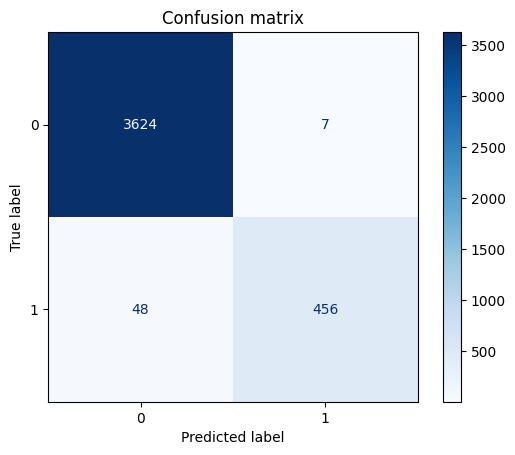

In [21]:
disp = ConfusionMatrixDisplay.from_estimator(
    model,
    x_test,
    y_test,
    # display_labels=['0', '1'],
    cmap=plt.cm.Blues,
    # normalize='true',
)
disp.ax_.set_title('Confusion matrix')

plt.show()

## Prediction for 5 emails

In [22]:
email = ['Hey, you have won a car !!!!. Conrgratzz',
     'Dear applicant, Your CV has been recieved. Best regards',
     'You have received $1000000 to your account',
     'Join with our whatsapp group',
     'Kindly check the previous email. Kind Regards']
emails = pd.DataFrame(email, columns=['EmailText'])
preProcess(emails)
print(emails)


                                           EmailText
0                  hey you have won a car conrgratzz
1  dear applicant your cv ha been recieved best r...
2                  you have received to your account
3                       join with our whatsapp group
4        kindly check the previous email kind regard


C:\Users\darklane\AppData\Local\Temp\ipykernel_9572\1845795358.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df['EmailText'] = df['EmailText'].str.replace('[^\w\s]', '')
C:\Users\darklane\AppData\Local\Temp\ipykernel_9572\1845795358.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df['EmailText'] = df['EmailText'].str.replace('\d+', '')
C:\Users\darklane\AppData\Local\Temp\ipykernel_9572\1845795358.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df['EmailText'] = df['EmailText'].str.replace('\s+', ' ')


In [23]:
emails['not_count'] = emails['EmailText'].apply(lambda x: len([1 for word in x.split() if word not in ham_words and word not in enwords and word not in wordnet.words()]))

In [24]:
emails

,EmailText,not_count
0,hey you have won a car conrgratzz,1
1,dear applicant your cv ha been recieved best r...,1
2,you have received to your account,0
3,join with our whatsapp group,0
4,kindly check the previous email kind regard,0


In [25]:
aaa = cv.transform(emails['EmailText']).toarray()
aaa = pd.DataFrame(aaa, columns=cv.get_feature_names_out())
aaa['not_count'] = emails['not_count']

In [26]:
prediction = model.predict(aaa)

email = pd.DataFrame(email, columns=['EmailText'])
email['predicted'] = prediction
email['predicted'].replace({0: 'ham', 1: 'spam'}, inplace=True)
email

,EmailText,predicted
0,"Hey, you have won a car !!!!. Conrgratzz",spam
1,"Dear applicant, Your CV has been recieved. Bes...",ham
2,You have received $1000000 to your account,ham
3,Join with our whatsapp group,ham
4,Kindly check the previous email. Kind Regards,ham
